In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import yfinance as yf


In [3]:
def load_data():
    data = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
    data = data[['Close']] 
    data.columns = ['price']
    return data

In [4]:

def create_features(data):
    for lag in [1, 2, 3, 5, 10]:
        data[f'lag_{lag}'] = data['price'].shift(lag)
    
    data['ma_7'] = data['price'].rolling(window=7).mean()
    data['ma_21'] = data['price'].rolling(window=21).mean()
 
    data['daily_pct_change'] = data['price'].pct_change()
 
    data['volatility_7'] = data['daily_pct_change'].rolling(window=7).std()
   
    data['target'] = data['price'].shift(-1)

    data = data.dropna()
    
    return data

def preprocess_data(data):
    X = data.drop(['price', 'target'], axis=1)
    y = data['target']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, X.columns

def temporal_train_test_split(X, y, test_size=0.2):
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    return X_train, X_test, y_train, y_test

def train_model(X_train, y_train):
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return predictions, mse

def plot_results(y_test, predictions, test_dates):
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Actual Prices', color='blue')
    plt.plot(test_dates, predictions, label='Predicted Prices', color='red', linestyle='--')
    plt.title('Stock Price Prediction with SVR')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def analyze_features(model, feature_names, X_train, y_train):
    correlations = pd.DataFrame({
        'feature': feature_names,
        'correlation': [np.corrcoef(X_train[:, i], y_train)[0, 1] for i in range(X_train.shape[1])]
    }).sort_values('correlation', key=abs, ascending=False)

    print("\nFeature Analysis:")
    print("1. Correlation with target price:")
    print(correlations)
    
    # Note: For RBF kernel, consider using permutation importance for feature analysis
    print("\nNote: For RBF kernel, exact feature importance isn't available.")
    print("Consider using permutation importance or switching to linear kernel for interpretability.")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



Model Performance:
Mean Squared Error: 53.1359
Root Mean Squared Error: 7.2894


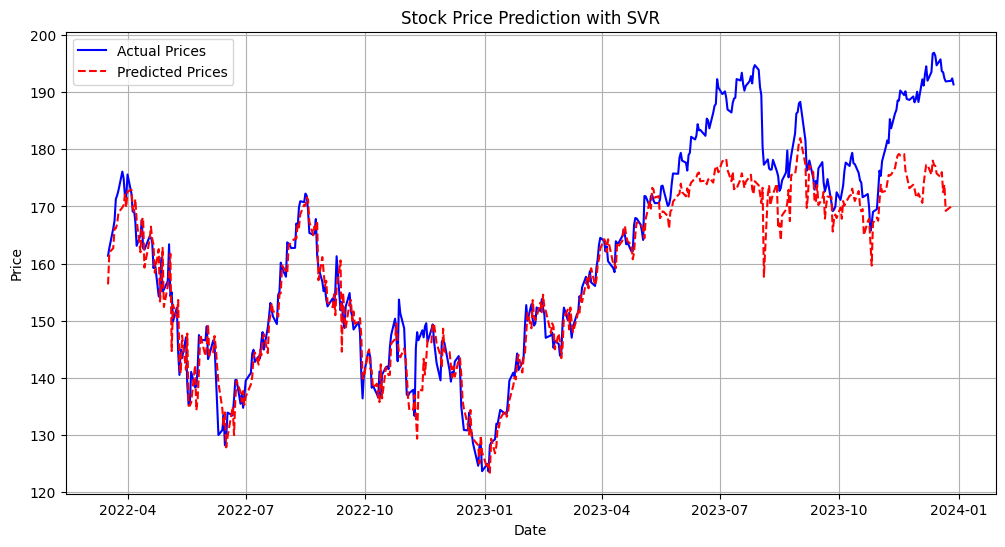


Feature Analysis:
1. Correlation with target price:
            feature  correlation
0             lag_1     0.998943
5              ma_7     0.998626
1             lag_2     0.998448
2             lag_3     0.998025
3             lag_5     0.997140
6             ma_21     0.996470
4            lag_10     0.994972
8      volatility_7     0.141399
7  daily_pct_change     0.026672

Note: For RBF kernel, exact feature importance isn't available.
Consider using permutation importance or switching to linear kernel for interpretability.


In [5]:

def main():
    # Load and prepare data
    data = load_data()
    data_with_features = create_features(data)
    X, y, feature_names = preprocess_data(data_with_features)
    
    # Split data (maintaining temporal order)
    X_train, X_test, y_train, y_test = temporal_train_test_split(X, y)
    test_dates = data_with_features.index[-len(y_test):]  # Get dates for test set
    
    # Train model
    model = train_model(X_train, y_train)
    
    # Evaluate
    predictions, mse = evaluate_model(model, X_test, y_test)
    
    # Results
    print(f"\nModel Performance:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {np.sqrt(mse):.4f}")
    
    # Visualization
    plot_results(y_test.values, predictions, test_dates)
    
    # Feature analysis
    analyze_features(model, feature_names, X_train, y_train)

if __name__ == "__main__":
    main()